In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In [47] used 0.000 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 6309.836 MiB


In [48]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [48] used 0.000 MiB RAM in 0.111s, peaked 0.000 MiB above current, total RAM usage 6309.836 MiB
In [48] used 0.000 MiB RAM in 0.107s, peaked 0.000 MiB above current, total RAM usage 6309.836 MiB


# Ideal Point Estimation

Here we perform Ideal Point Estimation of legislators in 113th Congress.

## Load Data
### Legislators
First we have to load in all legislators (this is for all of time, from GovTrack).

In [3]:
import ideal_point.raw_data

In [3] used 32.730 MiB RAM in 0.457s, peaked 0.000 MiB above current, total RAM usage 75.348 MiB


In [5]:
legislator_df = ideal_point.raw_data.legislators()
legislator_df.head()

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,thomas_id,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,1952-11-09,M,sen,OH,NaN,Democrat,https://www.brown.senate.gov,713 Hart Senate Office Building Washington DC ...,...,136.0,N00003535,S307,5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,1958-10-13,F,sen,WA,NaN,Democrat,https://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,...,172.0,N00007836,S275,26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,1943-10-05,M,sen,MD,NaN,Democrat,https://www.cardin.senate.gov,509 Hart Senate Office Building Washington DC ...,...,174.0,N00001955,S308,4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,1947-01-23,M,sen,DE,NaN,Democrat,http://www.carper.senate.gov,513 Hart Senate Office Building Washington DC ...,...,179.0,N00012508,S277,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,1960-04-13,M,sen,PA,NaN,Democrat,https://www.casey.senate.gov,393 Russell Senate Office Building Washington ...,...,1828.0,N00027503,S309,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


In [5] used 9.645 MiB RAM in 0.167s, peaked 2.754 MiB above current, total RAM usage 86.305 MiB


### Votes

Next we can load in all the votes. We get two dataframes from this, `vote_df` and `position_df`.

Each row of `vote_df` corresponds to one roll call vote (like on the passage of a bill).

Each row of `position_df` corresponds to one legislators position on a vote.

In [49]:
vote_df, position_df = ideal_point.raw_data.votes(legislator_df)


In [49] used -1940.648 MiB RAM in 22.238s, peaked 1941.867 MiB above current, total RAM usage 4369.188 MiB
In [49] used -1940.648 MiB RAM in 22.339s, peaked 1941.867 MiB above current, total RAM usage 4369.188 MiB


In [7]:
vote_df.head()

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,record_modified,requires,result,result_text,session,source_url,subject,type,updated_at,vote_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,quorum,h,...,NaN,QUORUM,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll001.xml,NaN,Call of the House,2014-06-18T11:22:24-04:00,h1-113.2013
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,procedural,h,...,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll010.xml,NaN,On the Motion to Adjourn,2014-06-18T11:22:23-04:00,h10-113.2013
2,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,recommit,h,...,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll100.xml,Preventing Greater Uncertainty in Labor-Manage...,On the Motion to Recommit,2014-06-18T11:22:04-04:00,h100-113.2013
3,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,passage,h,...,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll101.xml,Preventing Greater Uncertainty in Labor-Manage...,On Passage of the Bill,2014-06-18T11:22:04-04:00,h101-113.2013
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,procedural,h,...,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll102.xml,NaN,On Approving the Journal,2014-06-18T11:22:04-04:00,h102-113.2013


In [7] used 0.000 MiB RAM in 0.045s, peaked 0.000 MiB above current, total RAM usage 282.543 MiB


In [8]:
position_df.head()

,legislator_index,position,vote_index
0,39,Present,0
1,12270,Present,0
2,40,Present,0
3,376,Present,0
4,12276,Present,0


In [8] used 0.000 MiB RAM in 0.011s, peaked 0.000 MiB above current, total RAM usage 282.543 MiB


## Transform Data

Next we have to transform our data to a format we can train our model on.

Our observed data is basically `position_df`. but instead of categorical `position`s, we need them to
be 1s and 0s. Also, since we aren't using all of the legislators, we need to transform
the `legislator_index` into a relative index. We call this transformed dataframe `model_position_df`.

In [10]:
import ideal_point.ideal_point

In [10] used 9.359 MiB RAM in 0.849s, peaked 0.000 MiB above current, total RAM usage 292.023 MiB


In [11]:
model_position_df, model_legislator_index, model_vote_index = ideal_point.ideal_point.transform_data(position_df, vote_df, legislator_df)

In [11] used 19.238 MiB RAM in 1.204s, peaked 87.832 MiB above current, total RAM usage 311.262 MiB


In [12]:
model_position_df.head()

,legislator,position,vote
0,536,1,0
1,40,1,0
2,2,1,0
3,45,1,0
4,437,1,0


In [12] used 0.000 MiB RAM in 0.011s, peaked 0.000 MiB above current, total RAM usage 311.262 MiB


In [17]:
model_position_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508555 entries, 0 to 508554
Data columns (total 3 columns):
legislator    508555 non-null int64
position      508555 non-null int64
vote          508555 non-null int64
dtypes: int64(3)
memory usage: 11.6 MB
In [17] used 0.004 MiB RAM in 0.024s, peaked 0.000 MiB above current, total RAM usage 327.004 MiB
In [17] used 0.004 MiB RAM in 0.125s, peaked 0.000 MiB above current, total RAM usage 327.004 MiB


The two series `model_legislator_index` and `model_vote_index` map the values in `model_position_df` to the full dataframes, from index to value.

## Create Model

Now we can create our model, given we have observed those votes. The notation is based
on ["Comparing NOMINATE and IDEAL: Points of Difference and Monte Carlo Tests"](http://scholar-qa.princeton.edu/sites/default/files/jameslo/files/lsq_nomvsideal.pdf).

In [56]:
import ideal_point.gradient

In [56] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 4369.477 MiB
In [56] used 0.000 MiB RAM in 0.102s, peaked 0.000 MiB above current, total RAM usage 4369.477 MiB


In [57]:
g = ideal_point.gradient.Gradient(model_position_df)

In [57] used 0.000 MiB RAM in 2.048s, peaked 0.000 MiB above current, total RAM usage 4369.477 MiB
In [57] used 0.000 MiB RAM in 2.153s, peaked 0.000 MiB above current, total RAM usage 4369.477 MiB


## Train Model

Now we can run variational inference to compute estimated parameters for the model.

In [58]:
# g.run(100)
# params = g.params
# ideal_point.ideal_point.save_params(params)

-447893.681353
-447893.681353
-416059.785625
-392120.90219
-373295.945449
-358070.633321
-345472.482656
-334784.2786
-325414.794941
-316829.473271
-308505.915193
-299903.674368
-290450.686124
-279558.328865
-266684.473899
-251462.542749
-233890.703468
-214517.359581
-194487.502259
-175311.480235
-158376.131487
-144469.094178
-133641.468699
-125444.369753
-119271.823303
-114577.679685
-110943.463013
-108070.079433
-105749.041023
-103835.499785
-102228.122874
-100855.170769
-99665.1018945
-98620.2709136
-97692.6993069
-96861.2244406
-96109.5630203
-95424.9813232
-94797.369842
-94218.5897181
-93682.0039321
-93182.1357723
-92714.4162457
-92274.9945536
-91860.5939389
-91468.4006458
-91095.9773908
-90741.1952209
-90402.1793465
-90077.2657223
-89764.9659863
-89463.9389689
-89172.9674139
-88890.9388754
-88616.8299938
-88349.6935303
-88088.6476827
-87832.8673045
-87581.5767381
-87334.0440316
-87089.5763624
-86847.5165265
-86607.2403853
-86368.1551825
-86129.6986599
-85891.3389158
-85652.5749513

Or load it from disk, if we have already computed it (takes about an hour and a half on my computer)

In [51]:
params = ideal_point.ideal_point.load_params()

In [51] used 0.004 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 4369.207 MiB
In [51] used 0.004 MiB RAM in 0.111s, peaked 0.000 MiB above current, total RAM usage 4369.207 MiB


## Integrate Data

Now we can integrate the parameters we learned backed info our `vote_df` and `legislator_df`. We add a `ideology` column to both of them and filter out rows without ideal points. We also add a `bias` to the votes (which is greater if any senator is more likely to vote yes).

In [52]:
legislators_pt_df = ideal_point.ideal_point.leg_add_ideology(legislator_df, model_legislator_index, g.params)
vote_pt_df = ideal_point.ideal_point.vote_add_ideology_and_bias(vote_df, model_vote_index, g.params)

In [52] used 0.012 MiB RAM in 0.054s, peaked 0.000 MiB above current, total RAM usage 4369.219 MiB
In [52] used 0.012 MiB RAM in 0.156s, peaked 0.000 MiB above current, total RAM usage 4369.219 MiB


### Visualize Points

We can do a quick gut chuck of our legislator ideal points to make sure they seperate democrats and republicans

In [53]:
from altair import *

In [53] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 4369.219 MiB
In [53] used 0.000 MiB RAM in 0.103s, peaked 0.000 MiB above current, total RAM usage 4369.219 MiB


In [54] used 0.000 MiB RAM in 0.098s, peaked 0.000 MiB above current, total RAM usage 4369.219 MiB
In [54] used 0.258 MiB RAM in 0.199s, peaked 0.000 MiB above current, total RAM usage 4369.477 MiB


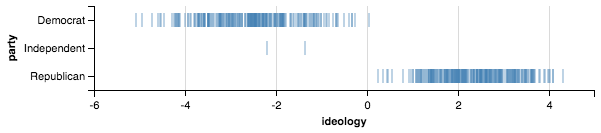

In [54]:
Chart(legislators_pt_df).mark_tick().encode(
    x='ideology:Q',
    y='party:O',
)

In [45]:
legislators_pt_df.sort_values(by=["ideology"])

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id,ideology
312,Schakowsky,Janice,1944-05-26,F,rep,IL,9.0,Democrat,http://schakowsky.house.gov,2367 Rayburn HOB; Washington DC 20515-1309,...,N00004724,NaN,57874.0,400360,6387.0,Jan Schakowsky,NaN,29911.0,Jan Schakowsky,-3.952305
457,Pocan,Mark,1964-08-14,M,rep,WI,2.0,Democrat,http://pocan.house.gov,313 Cannon HOB; Washington DC 20515-4902,...,N00033549,NaN,79688.0,412585,26238.0,Mark Pocan,NaN,21370.0,Mark Pocan,-3.902395
235,McGovern,James,1959-11-20,M,rep,MA,2.0,Democrat,http://mcgovern.house.gov,438 Cannon HOB; Washington DC 20515-2102,...,N00000179,NaN,45976.0,400263,552.0,NaN,NaN,29729.0,Jim McGovern (U.S. politician),-3.777557
253,Nadler,Jerrold,1947-06-13,M,rep,NY,10.0,Democrat,http://nadler.house.gov,2109 Rayburn HOB; Washington DC 20515-3210,...,N00000939,NaN,26159.0,400289,26980.0,NaN,NaN,29377.0,Jerrold Nadler,-3.700223
209,Lee,Barbara,1946-07-16,F,rep,CA,13.0,Democrat,http://lee.house.gov,2267 Rayburn HOB; Washington DC 20515-0513,...,N00008046,NaN,54579.0,400237,8315.0,NaN,NaN,29778.0,Barbara Lee,-3.685195
120,Edwards,Donna,1958-06-28,F,rep,MD,4.0,Democrat,http://donnaedwards.house.gov,2445 Rayburn HOB; Washington DC 20515-2004,...,N00028249,NaN,38535.0,412263,65085.0,NaN,NaN,20763.0,Donna Edwards,-3.667998
46,Becerra,Xavier,1958-01-26,M,rep,CA,34.0,Democrat,http://becerra.house.gov,1226 Longworth HOB; Washington DC 20515-0534,...,N00009774,NaN,26567.0,400021,26754.0,Xavier Becerra,NaN,29316.0,Xavier Becerra,-3.649893
322,Serrano,José,1943-10-24,M,rep,NY,15.0,Democrat,http://serrano.house.gov,2227 Rayburn HOB; Washington DC 20515-3215,...,N00001813,NaN,14306.0,400366,26981.0,NaN,NaN,29134.0,José E. Serrano,-3.544833
399,Lowenthal,Alan,1941-03-08,M,rep,CA,47.0,Democrat,http://lowenthal.house.gov,108 Cannon HOB; Washington DC 20515-0547,...,N00033274,NaN,93815.0,412521,16469.0,Alan Lowenthal,NaN,21313.0,Alan Lowenthal,-3.523955
121,Ellison,Keith,1963-08-04,M,rep,MN,5.0,Democrat,http://ellison.house.gov,2263 Rayburn HOB; Washington DC 20515-2305,...,N00028257,NaN,1022556.0,412215,38982.0,Keith Ellison,NaN,20727.0,Keith Ellison,-3.512681


In [45] used 0.000 MiB RAM in 0.109s, peaked 0.000 MiB above current, total RAM usage 6309.836 MiB


### Validation

Some of the most conservative members in our model include Mike Pompeo, who lead the house inquiry into Benghazi, and Randy Weber, who drew fire for a tweet declaring Barack Obama a "socialist dictator."

Some of the most liberal members include Jim McGovern, who represents the pioneer valley and Jerrold Nadler, who represents Manhattan's upper west side. The most liberal legislator, Jan Schakowsky, is a longtime critic of the Iraq war.

The house bills to remove voted on by all democrats are close to the democratic ideology.

In [46]:
r = vote_pt_df[vote_pt_df["question"].str.contains("To repeal the Patient Protection ")]
r

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,result,result_text,session,source_url,subject,type,updated_at,vote_id,bias,ideology
60,NaN,NaN,NaN,NaN,113.0,45.0,NaN,hr,recommit,h,...,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll153.xml,To repeal the Patient Protection and Affordabl...,On the Motion to Recommit,2014-06-18T11:21:59-04:00,h153-113.2013,-0.273224,-2.368123
61,NaN,NaN,NaN,NaN,113.0,45.0,NaN,hr,passage,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll154.xml,To repeal the Patient Protection and Affordabl...,On Passage of the Bill,2014-06-18T11:21:59-04:00,h154-113.2013,0.157992,2.444309


In [46] used 0.000 MiB RAM in 0.042s, peaked 0.000 MiB above current, total RAM usage 6309.836 MiB


This is to get bills linked w/ duplication data for now

In [26]:
vote_pt_df.sort_values("ideology", ascending=False)

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,result,result_text,session,source_url,subject,type,updated_at,vote_id,bias,ideology
1400,NaN,NaN,NaN,NaN,113.0,756.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll521.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-11-21T13:15:15-05:00,h521-113.2014,-0.479125,3.237360
96,NaN,NaN,NaN,NaN,113.0,243.0,NaN,hres,procedural,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll186.xml,"Providing for consideration of H.R. 2216, the ...",On Ordering the Previous Question,2014-06-18T11:21:56-04:00,h186-113.2013,-0.485389,3.232522
1401,NaN,NaN,NaN,NaN,113.0,756.0,NaN,hres,passage,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll522.xml,Providing for consideration of the bill (H.R. ...,On the Resolution,2014-11-21T13:15:15-05:00,h522-113.2014,-0.472516,3.231046
1337,NaN,NaN,NaN,NaN,113.0,694.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll465.xml,"Providing for consideration of H.Res. 676, pro...",On Ordering the Previous Question,2014-08-02T15:58:47-04:00,h465-113.2014,-0.471810,3.229739
1306,NaN,NaN,NaN,NaN,113.0,677.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll437.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-07-26T12:48:17-04:00,h437-113.2014,-0.479704,3.228667
210,NaN,NaN,NaN,NaN,113.0,274.0,NaN,hres,procedural,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll289.xml,"Providing for consideration of H.R. 1613, Oute...",On Ordering the Previous Question,2014-06-18T11:21:44-04:00,h289-113.2013,-0.573899,3.228001
438,NaN,NaN,NaN,NaN,113.0,366.0,NaN,hres,procedural,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll494.xml,Providing for consideration of the Senate amen...,On Ordering the Previous Question,2014-06-18T11:21:08-04:00,h494-113.2013,-0.477749,3.227057
485,NaN,NaN,NaN,NaN,113.0,90.0,NaN,hjres,unknown,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll536.xml,Making continuing appropriations for the Feder...,Table Appeal of the Ruling of the Chair,2014-06-18T11:20:59-04:00,h536-113.2013,-0.498078,3.225015
1329,NaN,NaN,NaN,NaN,113.0,693.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll458.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-08-01T13:15:17-04:00,h458-113.2014,-0.465140,3.223474
953,NaN,NaN,NaN,NaN,113.0,511.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll118.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-06-18T11:23:31-04:00,h118-113.2014,-0.471872,3.222037


In [26] used 0.004 MiB RAM in 0.106s, peaked 0.000 MiB above current, total RAM usage 354.871 MiB
In [26] used 0.016 MiB RAM in 0.210s, peaked 0.000 MiB above current, total RAM usage 354.883 MiB


## Text reuse

In [27]:
# vote_pt_df.to_csv("vote_pt_df.csv")
# run wtfpandasjoin.py to do the join. i kept trying to do w/ pandas and getting errors/bugs

In [27] used 0.016 MiB RAM in 0.108s, peaked 0.000 MiB above current, total RAM usage 354.887 MiB
In [27] used 0.004 MiB RAM in 0.208s, peaked 0.000 MiB above current, total RAM usage 354.887 MiB


In [22]:
import pandas as pd
import math
reuse_df = pd.DataFrame.from_csv("pairs_enhanced_again.txt")
# many, many, many unknowns b.c no votes. research opportunity. ideal point w/o vote. interesting... b/c many
# things are killed in committee. 
criterion = reuse_df['ideology_a'].map(lambda x: x != "unknown") 
reuse_df_no_unk = reuse_df[criterion]
reuse_df_no_unk["diff"] = abs(reuse_df_no_unk["ideology_a"].astype(float) - reuse_df_no_unk["ideology_b"].astype(float))
reuse_df_no_unk["diff"] = reuse_df_no_unk["diff"].astype(float)
t = reuse_df_no_unk.sort("diff", ascending =False)
t.head()

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,a_section_guid,bill_no_a,bill_kind_a,congress_a,version_code_a,issued_on_a,bfn,b_section_guid,bill_no_b,bill_kind_b,congress_b,version_code_b,issued_on_b,jac,ideology_a,ideology_b,diff
afn,,,,,,,,,,,,,,,,,
sections/H2BABCAF99FDE4CA697DDB7EEC8E7AD87_._govtrackdata_bills_hr_hr253_text-versions_ih_document.anno,H2BABCAF99FDE4CA697DDB7EEC8E7AD87,253,hr,113,ih,2013-01-15,sections/H67FBFE9E0F544717858E8D63C297C405_._g...,H67FBFE9E0F544717858E8D63C297C405,3979,hr,113,eah,2014-12-04,0.806667,-0.022435954878884536,2.1463933359323466,2.168829
sections/H2BABCAF99FDE4CA697DDB7EEC8E7AD87_._govtrackdata_bills_hr_hr253_text-versions_rh_document.anno,H2BABCAF99FDE4CA697DDB7EEC8E7AD87,253,hr,113,rh,2013-06-06,sections/HFC35A36A980346138EE041DDDF641CAC_._g...,HFC35A36A980346138EE041DDDF641CAC,3979,hr,113,enr,2014-01-01,0.806667,-0.022435954878884536,2.1463933359323466,2.168829
sections/H2BABCAF99FDE4CA697DDB7EEC8E7AD87_._govtrackdata_bills_hr_hr253_text-versions_ih_document.anno,H2BABCAF99FDE4CA697DDB7EEC8E7AD87,253,hr,113,ih,2013-01-15,sections/HFC35A36A980346138EE041DDDF641CAC_._g...,HFC35A36A980346138EE041DDDF641CAC,3979,hr,113,enr,2014-01-01,0.806667,-0.022435954878884536,2.1463933359323466,2.168829
sections/H2BABCAF99FDE4CA697DDB7EEC8E7AD87_._govtrackdata_bills_hr_hr253_text-versions_rh_document.anno,H2BABCAF99FDE4CA697DDB7EEC8E7AD87,253,hr,113,rh,2013-06-06,sections/H67FBFE9E0F544717858E8D63C297C405_._g...,H67FBFE9E0F544717858E8D63C297C405,3979,hr,113,eah,2014-12-04,0.806667,-0.022435954878884536,2.1463933359323466,2.168829
sections/H1E3DB7F859F943A5BC6DD7E714368671_._govtrackdata_bills_hres_hres441_text-versions_eh_document.anno,H1E3DB7F859F943A5BC6DD7E714368671,441,hres,113,eh,2013-12-12,sections/HC55E6E70529F400981EA5B78BB23D7C8_._g...,HC55E6E70529F400981EA5B78BB23D7C8,3979,hr,113,eah,2014-12-04,0.911111,0.37265358475971155,2.1463933359323466,1.773740


#### Bipartisanship?

It appears that a liberal section 

In [29]:
import pandas as pd
import math
reuse_df = pd.DataFrame.from_csv("pairs_enhanced_again.txt")
# many, many, many unknowns b.c no votes. research opportunity. ideal point w/o vote. interesting... b/c many
# things are killed in committee. 
criterion = reuse_df['ideology_a'].map(lambda x: x != "unknown") 
reuse_df_no_unk = reuse_df[criterion]
reuse_df_no_unk["sa"] = reuse_df_no_unk["ideology_a"].astype(float)> 0
reuse_df_no_unk["sb"] = reuse_df_no_unk["ideology_b"].astype(float)> 0
reuse_df_no_unk["diff"] = reuse_df_no_unk["sa"] == reuse_df_no_unk["sb"]
c2 = reuse_df_no_unk["diff"].map(lambda x: x == False) 
reuse_df_no_unk = reuse_df_no_unk[c2]
reuse_df_no_unk.shape

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

(4, 19)